## Build a Basic Chatboth with Langgraph(Graph API)

In [127]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages



In [128]:
class State(TypedDict):
    messages:Annotated[list,add_messages] ## add_message is acting as reducer

graph_builder=StateGraph(State)
graph_builder

In [129]:
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

import os
os.environ["GROQ_API_KEY"] = "GROQ_API_KEY"
llm = ChatGroq(model="llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000021FEEAF81C0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021FEEC0DF40>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [131]:
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [132]:
graph_builder=StateGraph(State)
##Adding nodes
graph_builder.add_node("llmchatbot",chatbot)

##Adding edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

##compile the graph
compiled_graph  = graph_builder.compile()

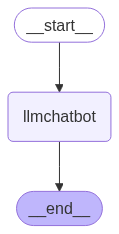

In [133]:
from IPython.display import Image, display


try:
    display(Image(compiled_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Error displaying image:", e)


In [134]:
response = compiled_graph.invoke({"messages":"Hi"})
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [135]:
for event in compiled_graph.stream({"messages":"hi how r u?"}):
    for value in event.values():
        print(value["messages"][-1].content)

Hi! I'm just an AI, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help you with any questions or tasks you may have! How about you? How's your day going so far?


##Chatbot with Tool

In [136]:
from langchain_tavily import TavilySearch


tool  = TavilySearch(max_search=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interaction

In [137]:
import sys
print(sys.executable)

d:\AgenticAI\.venv\Scripts\python.exe


In [138]:
import pkg_resources
installed_packages = {pkg.key for pkg in pkg_resources.working_set}
print('langchain-tavily' in installed_packages)

True


In [139]:
##Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    args:
         a(int): first int
         b(int): second int
        
    Returns:
        int:output int
    
    """

In [140]:
tools=[tool,multiply]


In [141]:
llm_with_tool=llm.bind_tools(tools)
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000021FEEAF81C0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021FEEC0DF40>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

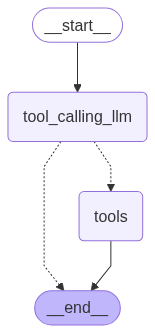

In [142]:
### Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition



## Node Defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## create a graph
builder= StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## add edges 
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # if the latest messgaes (result) from assistant is a tool call ->tools_condition routes to tools
    # if the latest messgaes (result) from assistant is a not tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)


##compile the graph
graph1 = builder.compile()
display(Image(graph1.get_graph().draw_mermaid_png()))


In [143]:
respone =graph1.invoke({"messages":"what is the recent ai news"})

In [144]:
respone['messages'][-1].content

'</tool-use>\n{\n  "tool_calls": [\n    {\n      "id": "pending",\n      "type": "function",\n      "function": {\n        "name": "tavily_search"\n      },\n      "parameters": {\n        "query": "recent ai news",\n        "search_depth": "advanced",\n        "topic": "news",\n        "include_images": false\n      }\n    }\n  ]\n}</tool-use>'

In [145]:
for m in response["messages"]:
    print(m)

content='Hi' additional_kwargs={} response_metadata={} id='44f19a8e-452a-4b41-875d-772c01171e9d'
content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?" additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.043261518, 'prompt_time': 0.005005788, 'queue_time': 0.29945486, 'total_time': 0.048267306}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6d1c2b0784', 'finish_reason': 'stop', 'logprobs': None} id='run--72161d80-bcbd-4cb7-b6b7-9b561a379637-0' usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36}


In [148]:
respone =graph1.invoke({"messages":"what is 2 multiply by 3"})
respone['messages'][-1].content

for m in response["messages"]:
    print(m)

content='Hi' additional_kwargs={} response_metadata={} id='44f19a8e-452a-4b41-875d-772c01171e9d'
content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?" additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.043261518, 'prompt_time': 0.005005788, 'queue_time': 0.29945486, 'total_time': 0.048267306}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6d1c2b0784', 'finish_reason': 'stop', 'logprobs': None} id='run--72161d80-bcbd-4cb7-b6b7-9b561a379637-0' usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36}
